In [43]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import Holt, ExponentialSmoothing

warnings.filterwarnings('ignore')

Reading in our store data.

In [44]:
df = pd.read_csv('stores.csv', index_col=0)
df.head()

,sale_amount,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state,sale_total,day_of_week,month
sale_date,,,,,,,,,,,
2013-01-01,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,10.92,Tuesday,January
2013-01-01,26,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,12018 Perrin Beitel Rd,78217,San Antonio,TX,218.40,Tuesday,January
2013-01-01,27,Mama Marys,Pizza Sauce,4.65,12018 Perrin Beitel Rd,78217,San Antonio,TX,125.55,Tuesday,January
2013-01-01,54,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,15000 San Pedro Ave,78232,San Antonio,TX,453.60,Tuesday,January
2013-01-01,35,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,735 SW Military Dr,78221,San Antonio,TX,294.00,Tuesday,January


It gets read in as a string. I have to make sure to recast it as a datetime object.

In [45]:
df.index = pd.to_datetime(df.index)

We have tp split our data before we model. I'm going to do a human-based split.

In [46]:
train = df.loc[:'2015']
validate = df.loc['2016']
test = df.loc['2017']

train.shape, validate.shape, test.shape

((547500, 11), (183000, 11), (182500, 11))

We need to perform an aggregation to have one point of data per day. We can resample by the day and take the sum of the sales_total column.

In [47]:
day_train = train.resample('d').sale_total.sum()
day_val = validate.resample('d').sale_total.sum()
day_test = test.resample('d').sale_total.sum()

day_train.head()

sale_date
2013-01-01    73844.01
2013-01-02    73570.58
2013-01-03    78169.48
2013-01-04    84467.73
2013-01-05    87621.85
Freq: D, Name: sale_total, dtype: float64

We can visualize out split.

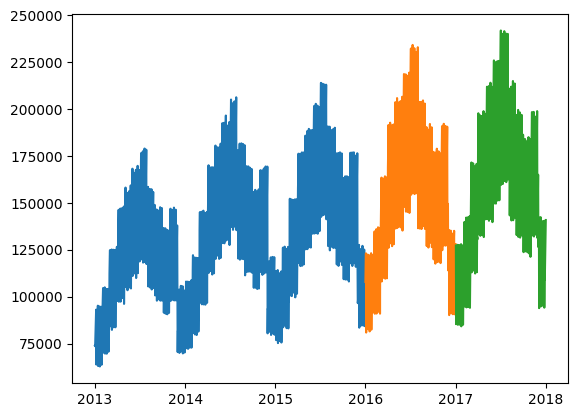

In [48]:
plt.plot(day_train)
plt.plot(day_val)
plt.plot(day_test)
plt.show()

Now that our data is properly split, let's try two different modeling approaches:
- One baseline model (rolling average)
- One non-baseline model (Holt's seasonal trend)

In [49]:
rolling = round(day_train.rolling(30).mean()[-1], 2)
rolling

105739.12

In [50]:
preds = pd.DataFrame({'actual': day_val,
                      'month_rolling': rolling})

preds.head()

,actual,month_rolling
sale_date,,
2016-01-01,107875.26,105739.12
2016-01-02,114330.43,105739.12
2016-01-03,123144.91,105739.12
2016-01-04,80873.97,105739.12
2016-01-05,95429.90,105739.12


We can also creat a rolling average of the last 180 days in our dataset. This may perform better (or worse) than our monthly rolling average baseline.

In [51]:
hy_rolling = round(day_train.rolling(180).mean()[-1], 2)

In [52]:
preds['hy_rolling'] = hy_rolling
preds.head()

,actual,month_rolling,hy_rolling
sale_date,,,
2016-01-01,107875.26,105739.12,145666.45
2016-01-02,114330.43,105739.12,145666.45
2016-01-03,123144.91,105739.12,145666.45
2016-01-04,80873.97,105739.12,145666.45
2016-01-05,95429.90,105739.12,145666.45


Defining a simple function to evaluate 

In [53]:
def eval_preds(df, predictions, actual='actual'):
    
    return round(sqrt(mean_squared_error(df[actual], df[predictions])), 2)

In [54]:
eval_preds(preds, 'month_rolling')

57384.82

In [62]:
eval_preds(preds, 'hy_rolling')

34405.71

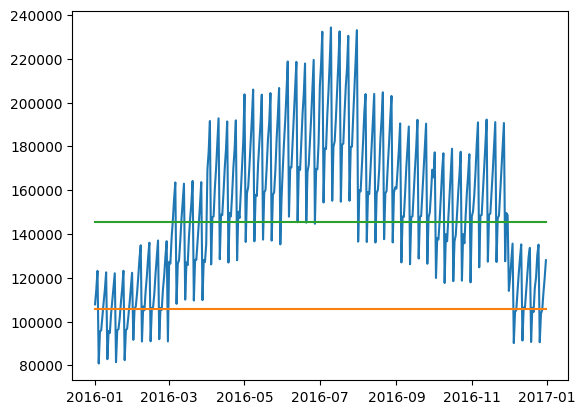

In [55]:
plt.plot(preds['actual'])
plt.plot(preds['month_rolling'])
plt.plot(preds['hy_rolling'])
plt.show()

Thing i passed into my model:
- My train dataset
- The number of observations before the seasonality repeats(365)
- The type of trend in my dataset (it's additive)
- Seasonality is also set to additive.
 
Finally, hiding at the end, I am calling the .fit() method on my model.

In [56]:
hst_model = ExponentialSmoothing(day_train, seasonal_periods=365, trend='add', seasonal='add').fit()

When i am calling the .forecast() method on my model object, I specify how many observations to produce. In this case, I am asking for a number of observation equal to the days in the validate set.

In [57]:
hst_model.forecast(day_val.shape[0])

2016-01-01    100114.134028
2016-01-02    108505.451715
2016-01-03    112492.190484
2016-01-04    120205.367567
2016-01-05    104386.511068
                  ...      
2016-12-27    133416.358399
2016-12-28    115047.490633
2016-12-29    105504.232098
2016-12-30    110782.483640
2016-12-31    111645.544104
Freq: D, Length: 366, dtype: float64

I will add this predictions to my predictions dataframe so i can evaluate them!

In [58]:
preds['hst'] = hst_model.forecast(day_val.shape[0])

After evaluating my predictions, I see that my model outperforms both baselines.

In [59]:
eval_preds(preds, 'hst')

25942.97

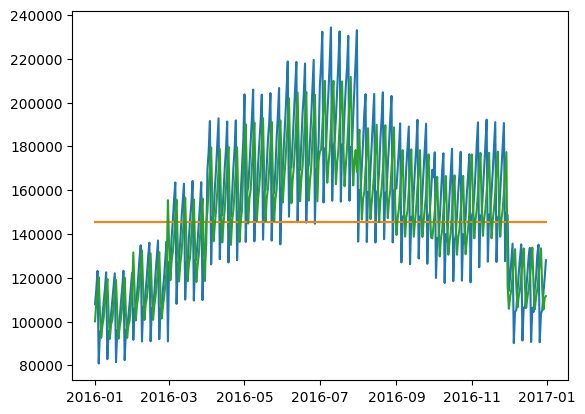

In [63]:
plt.plot(preds['actual'])
plt.plot(preds['hy_rolling'])
plt.plot(preds['hst'])
plt.show()